In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/home/cristiandugacicu/projects/personal/zoomcamp/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# !wget "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv" -O data-3.csv
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

df = pd.read_csv("/home/cristiandugacicu/projects/personal/zoomcamp/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.columns = df.columns.str.lower().str.replace(" ", "_")

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

# fix categorical values
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(" ", "_")

# fix nan values if they are marked with another char    
tc = pd.to_numeric(df.totalcharges, errors='coerce')
print("Missing totalcharges count:",tc.isnull().sum())
df.totalcharges = tc
df.totalcharges = df.totalcharges.fillna(0)

# fix yes/no with 0/1
df.churn = (df.churn == "yes").astype(int)

df.head().T
# df.isnull().sum()

/home/cristiandugacicu/projects/personal/zoomcamp/course3.ipynb
/home/cristiandugacicu/projects/personal/zoomcamp/AB_NYC_2019.csv.zip
/home/cristiandugacicu/projects/personal/zoomcamp/AB_NYC_2019.csv
/home/cristiandugacicu/projects/personal/zoomcamp/homework3.ipynb
/home/cristiandugacicu/projects/personal/zoomcamp/data.csv
/home/cristiandugacicu/projects/personal/zoomcamp/course4.ipynb
/home/cristiandugacicu/projects/personal/zoomcamp/WA_Fn-UseC_-Telco-Customer-Churn.csv
/home/cristiandugacicu/projects/personal/zoomcamp/.ipynb_checkpoints/course4-checkpoint.ipynb
/home/cristiandugacicu/projects/personal/zoomcamp/.ipynb_checkpoints/course3-checkpoint.ipynb
/home/cristiandugacicu/projects/personal/zoomcamp/.ipynb_checkpoints/homework3-checkpoint.ipynb
Missing totalcharges count: 11


,0,1,2,3,4
customerid,7590-vhveg,5575-gnvde,3668-qpybk,7795-cfocw,9237-hqitu
gender,female,male,male,male,female
seniorcitizen,0,0,0,0,0
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no


In [2]:
# Setup validation framework
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

df_train = df_train.reset_index(drop="true")
df_val = df_val.reset_index(drop="true")
df_test = df_test.reset_index(drop="true")

y_full_train = df_full_train.churn.values
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_test["churn"]
del df_val["churn"]
del df_train["churn"]
df_train.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges'],
      dtype='object')

In [3]:
# EDA Exploritory Data Analysis
numerical_columns = ["monthlycharges", "totalcharges", "tenure"]
categorical_columns = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

df_full_train.churn.value_counts()
df_full_train.churn.value_counts(normalize=True)
df_full_train.churn.mean()
df_full_train.groupby("gender").churn.agg(["mean", "count"])


,mean,count
gender,,
female,0.276824,2796
male,0.263214,2838


In [4]:
# Hot Encoding
from sklearn.feature_extraction import DictVectorizer

# train_dicts = df_train[["gender", "contract", "tenure"]].iloc[:100].to_dict(orient='records')
train_dicts = df_train[categorical_columns+numerical_columns].to_dict(orient='records')
dv = DictVectorizer(sparse = False) #sparse =True => enables sparse matrix by compressing 0 values
dv.fit(train_dicts)
dv.transform(train_dicts)  
display("column names:",dv.get_feature_names()) # column names

X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical_columns+numerical_columns].to_dict(orient='records')
X_val = dv.transform(val_dicts)


'column names:'

['contract=month-to-month',
 'contract=one_year',
 'contract=two_year',
 'dependents=no',
 'dependents=yes',
 'deviceprotection=no',
 'deviceprotection=no_internet_service',
 'deviceprotection=yes',
 'gender=female',
 'gender=male',
 'internetservice=dsl',
 'internetservice=fiber_optic',
 'internetservice=no',
 'monthlycharges',
 'multiplelines=no',
 'multiplelines=no_phone_service',
 'multiplelines=yes',
 'onlinebackup=no',
 'onlinebackup=no_internet_service',
 'onlinebackup=yes',
 'onlinesecurity=no',
 'onlinesecurity=no_internet_service',
 'onlinesecurity=yes',
 'paperlessbilling=no',
 'paperlessbilling=yes',
 'partner=no',
 'partner=yes',
 'paymentmethod=bank_transfer_(automatic)',
 'paymentmethod=credit_card_(automatic)',
 'paymentmethod=electronic_check',
 'paymentmethod=mailed_check',
 'phoneservice=no',
 'phoneservice=yes',
 'seniorcitizen',
 'streamingmovies=no',
 'streamingmovies=no_internet_service',
 'streamingmovies=yes',
 'streamingtv=no',
 'streamingtv=no_internet_servic

In [5]:
#Logistic regretion
from sklearn import linear_model

model = linear_model.LogisticRegression()

model.fit(X_train, y_train)
weights = model.coef_[0].round(3) # weights
model.intercept_ # bias, w0

weights_with_featureNames = dict(zip(dv.get_feature_names(), weights))
display(weights_with_featureNames)

model.predict(X_val) #hard predictions:  y= {0,1}
proba = model.predict_proba(X_val) #hard predictions:  y= 0->1. Returns probablility as [% for 0,% for 1]
y_pred_val = proba[:,1]  #take column 1

churn_decision = (y_pred_val >= 0.5)
customers_that_will_leave = df_val[churn_decision].customerid  # the people who will churn

#check average accuracy on y_val
(churn_decision.astype(int) == y_val).mean()

df_pred = pd.DataFrame()
df_pred["probability"] = y_pred_val
df_pred["prediction"] = churn_decision.astype(int)
df_pred["actual"] = y_val
df_pred["prediction_correct"] = df_pred.prediction == df_pred.actual
print("Accuracy % on y_val:",df_pred.prediction_correct.mean())


/home/cristiandugacicu/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'contract=month-to-month': 0.475,
 'contract=one_year': -0.175,
 'contract=two_year': -0.408,
 'dependents=no': -0.03,
 'dependents=yes': -0.078,
 'deviceprotection=no': 0.063,
 'deviceprotection=no_internet_service': -0.089,
 'deviceprotection=yes': -0.081,
 'gender=female': -0.034,
 'gender=male': -0.074,
 'internetservice=dsl': -0.335,
 'internetservice=fiber_optic': 0.317,
 'internetservice=no': -0.089,
 'monthlycharges': 0.004,
 'multiplelines=no': -0.259,
 'multiplelines=no_phone_service': 0.142,
 'multiplelines=yes': 0.009,
 'onlinebackup=no': 0.063,
 'onlinebackup=no_internet_service': -0.089,
 'onlinebackup=yes': -0.081,
 'onlinesecurity=no': 0.266,
 'onlinesecurity=no_internet_service': -0.089,
 'onlinesecurity=yes': -0.284,
 'paperlessbilling=no': -0.231,
 'paperlessbilling=yes': 0.123,
 'partner=no': -0.166,
 'partner=yes': 0.058,
 'paymentmethod=bank_transfer_(automatic)': -0.087,
 'paymentmethod=credit_card_(automatic)': -0.032,
 'paymentmethod=electronic_check': 0.07,
 

Accuracy % on y_val: 0.8034066713981547


In [6]:
# Small Model Interpretation

small = ["contract", "tenure", "monthlycharges"]
dicts_train_small = df_train[small].to_dict(orient="records")
dicts_val_small = df_val[small].to_dict(orient="records")

dv_small = DictVectorizer(sparse=False)
dv_small.fit(dicts_train_small)

dv_small.get_feature_names()  # => ['contract=month-to-month', 'contract=one_year', 'contract=two_year', 'monthlycharges', 'tenure']

X_train_small = dv_small.transform(dicts_train_small)
model_small = linear_model.LogisticRegression()
model_small.fit(X_train_small, y_train)
w0 = model_small.intercept_[0] # bias, w0
w = model_small.coef_[0].round(3) # weights

weights_with_names = dict(zip(dv_small.get_feature_names(), w))
print("w0 =", w0, "weights_with_names: ", weights_with_names)


w0 = -2.4767756616275904 weights_with_names:  {'contract=month-to-month': 0.97, 'contract=one_year': -0.025, 'contract=two_year': -0.949, 'monthlycharges': 0.027, 'tenure': -0.036}


In [7]:
#Using the model

def train_model(dataFrame, y):
    dicts = dataFrame[categorical_columns+numerical_columns].to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    dv.fit(dicts)
    X = dv.transform(dicts)

    model = linear_model.LogisticRegression()
    model.fit(X, y)
    return model

model_full_train = train_model(df_full_train,y_full_train)

w0 = model_full_train.intercept_[0] # bias, w0
w = model_full_train.coef_[0].round(3) # weigh

#test:
dicts_test = df_test[categorical_columns+numerical_columns].to_dict(orient="records")
X_test = dv.transform(dicts_test)
y_pred = model_full_train.predict_proba(X_test)[:,1]
churn_decision = (y_pred >= 0.5)
print("Model accuracy based on test data:", (churn_decision == y_test).mean())
print("Customers that will churn:", (churn_decision == y_test).sum(), "from", len(y_test))


#example: Prediction on 1 customer
customer = df_test.iloc[10]
X_customer = dv.transform([customer])
y_customer = model_full_train.predict_proba(X_customer)[0,1]
customer_churn = (y_customer>=0.5)
print("Probability of Customer #1 to churn:",customer_churn,",Actual churn:", y_test[10])

Model accuracy based on test data: 0.815471965933286
Customers that will churn: 1149 from 1409
Probability of Customer #1 to churn: False ,Actual churn: 0


Model accuracy (thresholds=0.00): 0.247
Model accuracy (thresholds=0.05): 0.480
Model accuracy (thresholds=0.10): 0.603
Model accuracy (thresholds=0.15): 0.674
Model accuracy (thresholds=0.20): 0.707
Model accuracy (thresholds=0.25): 0.746
Model accuracy (thresholds=0.30): 0.771
Model accuracy (thresholds=0.35): 0.778
Model accuracy (thresholds=0.40): 0.791
Model accuracy (thresholds=0.45): 0.803
Model accuracy (thresholds=0.50): 0.815
Model accuracy (thresholds=0.55): 0.819
Model accuracy (thresholds=0.60): 0.814
Model accuracy (thresholds=0.65): 0.806
Model accuracy (thresholds=0.70): 0.800
Model accuracy (thresholds=0.75): 0.781
Model accuracy (thresholds=0.80): 0.766
Model accuracy (thresholds=0.85): 0.754
Model accuracy (thresholds=0.90): 0.753
Model accuracy (thresholds=0.95): 0.753
Model accuracy (thresholds=1.00): 0.753
Max Model accuracy is 0.819


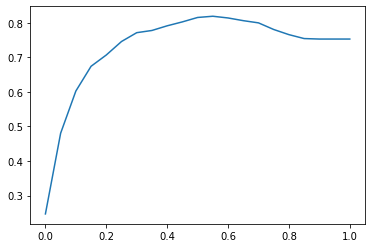

In [8]:
import matplotlib.pyplot as plt
from sklearn import metrics

thresholds = np.linspace(0, 1, 21)

scores = []
for t in thresholds:
#     churn_decision = (y_pred >= t)
#     score = (churn_decision == y_test).mean()
#   OR using sklearn:
    score = metrics.accuracy_score(y_test, y_pred >= t)
    scores.append(score)
    print('Model accuracy (thresholds=%.2f): %.3f' % (t, score))
 
print('Max Model accuracy is %.3f' % (max(scores)))
plt.plot(thresholds, scores)

Customers that we predict will churn and they do churn (thresholds=0.50): 200
Customers that we predict will not churn and they do not churn  (thresholds=0.50): 949
Customers that we predict will churn but they do not churn  (thresholds=0.50): 112
Customers that we predict will not churn but they do churn  (thresholds=0.50): 148

Confusion_matrix:
 [[949 112]
 [148 200]]

Confusion_matrix %:
 [[0.67 0.08]
 [0.11 0.14]]


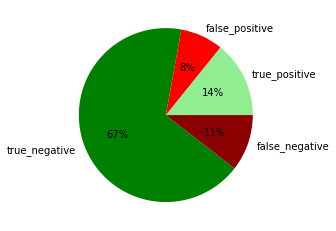

In [9]:
# Confusion Table

# churn_decision:
t = 0.5

predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

actual_positive = (y_test >= t)
actual_negative = (y_test < t)

true_positive = (predict_positive & actual_positive).sum()
true_negative = (predict_negative & actual_negative).sum()
false_positive = (predict_positive & actual_negative).sum()
false_negative = (predict_negative & actual_positive).sum()

print('Customers that we predict will churn and they do churn (thresholds=%.2f): %1.0f' % (t, true_positive))
print('Customers that we predict will not churn and they do not churn  (thresholds=%.2f): %1.0f' % (t, true_negative))

print('Customers that we predict will churn but they do not churn  (thresholds=%.2f): %1.0f' % (t, false_positive))
print('Customers that we predict will not churn but they do churn  (thresholds=%.2f): %1.0f' % (t, false_negative))

labels = ["true_positive", "false_positive", "true_negative", "false_negative"]
results = [true_positive, false_positive, true_negative, false_negative]
colors = ["lightgreen", "red", "green", "darkred"]
plt.pie(results, labels=labels, colors=colors, autopct='%1.0f%%')


confusion_matrix = np.array([
    [true_negative, false_positive],
    [false_negative, true_positive]
])
print("\nConfusion_matrix:\n",confusion_matrix)
print("\nConfusion_matrix %:\n",((confusion_matrix/confusion_matrix.sum()).round(2)))


In [10]:
#Precision #Recall

precission = true_positive / (true_positive + false_positive)
print("precission=",precission)

#Recall
recall = true_positive / (true_positive + false_negative)
print("recall=",recall)


#TP rate  #FP rate

tpr = true_positive / (true_positive + false_negative)
print("tpr=",tpr)

fpr = false_positive / (false_positive + true_negative)
print("fpr=",fpr)

precission= 0.6410256410256411
recall= 0.5747126436781609
tpr= 0.5747126436781609
fpr= 0.1055607917059378


,threshold,true_positive,true_negative,false_positive,false_negative,tpr,fpr
0,0.0,1409,0,0,0,1.000000,NaN
10,0.1,335,514,547,13,0.962644,0.515551
20,0.2,300,696,365,48,0.862069,0.344015
30,0.3,278,809,252,70,0.798851,0.237512
40,0.4,239,876,185,109,0.686782,0.174364
50,0.5,200,949,112,148,0.574713,0.105561
60,0.6,150,997,64,198,0.431034,0.060320
70,0.7,86,1041,20,262,0.247126,0.018850
80,0.8,18,1061,0,330,0.051724,0.000000
90,0.9,0,1061,0,348,0.000000,0.000000


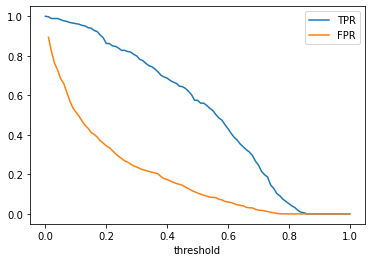

In [11]:
# thresholds / tpr    # thresholds / tpr

def tpr_fpr_dataframe(y, y_pred1):    
    thresholds = np.linspace(0, 1, 101)
    scores = []

    for t in thresholds:
        predict_positive = (y_pred1 >= t)
        predict_negative = (y_pred1 < t)

        actual_positive = (y >= t)
        actual_negative = (y < t)

        true_positive = (predict_positive & actual_positive).sum()
        true_negative = (predict_negative & actual_negative).sum()
        false_positive = (predict_positive & actual_negative).sum()
        false_negative = (predict_negative & actual_positive).sum()
        scores.append((t,true_positive,true_negative,false_positive,false_negative))

    scores_columns = ["threshold","true_positive","true_negative","false_positive","false_negative"]
    df_scores = pd.DataFrame(scores, columns=scores_columns)

    df_scores["tpr"] = df_scores.true_positive / (df_scores.true_positive + df_scores.false_negative)
    df_scores["fpr"] = df_scores.false_positive / (df_scores.false_positive + df_scores.true_negative)
    return df_scores

df_total_scores = tpr_fpr_dataframe(y_test, y_pred)
display(df_total_scores[::10])

plt.plot(df_total_scores.threshold, df_total_scores.tpr, label="TPR")
plt.plot(df_total_scores.threshold, df_total_scores.fpr, label="FPR")
plt.xlabel("threshold")
plt.legend()




,threshold,true_positive,true_negative,false_positive,false_negative,tpr,fpr
0,0.0,1409,0,0,0,1.000000,NaN
10,0.1,307,98,963,41,0.882184,0.907634
20,0.2,271,203,858,77,0.778736,0.808671
30,0.3,237,298,763,111,0.681034,0.719133
40,0.4,212,412,649,136,0.609195,0.611687
50,0.5,177,518,543,171,0.508621,0.511781
60,0.6,137,628,433,211,0.393678,0.408106
70,0.7,102,740,321,246,0.293103,0.302545
80,0.8,67,844,217,281,0.192529,0.204524
90,0.9,35,955,106,313,0.100575,0.099906


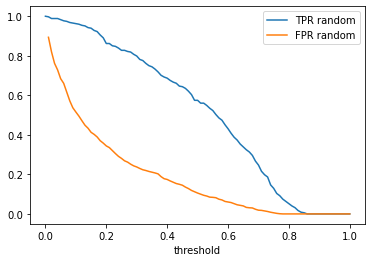

In [12]:
# Random prediction

np.random.seed(1)
y_rand = np.random.uniform(0,1,size=len(y_test))

((y_rand >= 0.5) == y_test).mean()

df_total_scores_random = tpr_fpr_dataframe(y_test, y_rand)
display(df_total_scores_random[::10])

plt.plot(df_total_scores_random.threshold, df_total_scores.tpr, label="TPR random")
plt.plot(df_total_scores_random.threshold, df_total_scores.fpr, label="FPR random")
plt.xlabel("threshold")
plt.legend()



845

564

,threshold,true_positive,true_negative,false_positive,false_negative,tpr,fpr
0,0.0,1409,0,0,0,1.000000,NaN
10,0.1,564,141,704,0,1.000000,0.833136
20,0.2,564,282,563,0,1.000000,0.666272
30,0.3,564,423,422,0,1.000000,0.499408
40,0.4,564,564,281,0,1.000000,0.332544
50,0.5,564,704,141,0,1.000000,0.166864
60,0.6,564,845,0,0,1.000000,0.000000
70,0.7,423,845,0,141,0.750000,0.000000
80,0.8,282,845,0,282,0.500000,0.000000
90,0.9,141,845,0,423,0.250000,0.000000


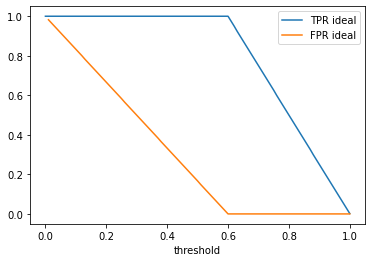

In [13]:
# Ideal prediction for y_test data

# num_negative = (y_test == 0).sum()
# num_positive = (y_test == 1).sum()
num_negative = int(len(y_test) * 0.6)   # 60% are not churn
num_positive = len(y_test)-num_negative  # 40% are churn


display(num_negative, num_positive)
# % = 1-348/(1061+348)

y_ideal = np.repeat([0,1], [num_negative, num_positive])
y_ideal_pred = np.linspace(0, 1, len(y_test))

# ((y_ideal_pred >= 0.0.75301)  == y_ideal).mean()

df_total_scores_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
display(df_total_scores_ideal[::10])

plt.plot(df_total_scores_ideal.threshold, df_total_scores_ideal.tpr, label="TPR ideal")
plt.plot(df_total_scores_ideal.threshold, df_total_scores_ideal.fpr, label="FPR ideal")
plt.xlabel("threshold")
plt.legend()




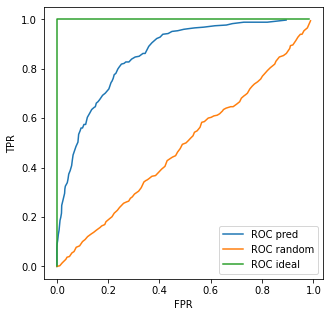

In [14]:
# ROC Curve:   FPT / TPR

plt.figure(figsize=(5,5))
plt.plot(df_total_scores.fpr, df_total_scores.tpr, label="ROC pred")
plt.plot(df_total_scores_random.fpr, df_total_scores_random.tpr, label="ROC random")
plt.plot(df_total_scores_ideal.fpr, df_total_scores_ideal.tpr, label="ROC ideal")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()

In [15]:
import sklearn.metrics

df_total_scores_auc = metrics.auc(df_total_scores.fpr.fillna(1), df_total_scores.tpr)
df_total_scores_random_auc = metrics.auc(df_total_scores_random.fpr.fillna(1), df_total_scores_random.tpr)
df_total_scores_ideal_auc = metrics.auc(df_total_scores_ideal.fpr.fillna(1), df_total_scores_ideal.tpr)

print("df_total_scores_auc:", df_total_scores_auc)
print("df_total_scores_random_auc:", df_total_scores_random_auc)
print("df_total_scores_ideal_auc:", df_total_scores_ideal_auc)

# OR
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc = metrics.auc(df_total_scores_random.fpr.fillna(1), df_total_scores_random.tpr)

df_total_scores_auc: 0.8571411160583704
df_total_scores_random_auc: 0.4871813621935498
df_total_scores_ideal_auc: 1.0


In [59]:
# !pip install tqdm
import warnings
warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')


df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

#Cross Validation
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

def train(dataFrame, y, C):
    dicts = dataFrame.to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    X = dv.fit_transform(dicts)

    model = linear_model.LogisticRegression(C=C)
    model.fit(X, y)
    return dv, model

def predict(dataFrame, dv, model):
    dicts = dataFrame.to_dict(orient="records")
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    return y_pred


df_full_train_selected1 = df_full_train[categorical_columns+numerical_columns]

splits = 5

for C in tqdm([ 0.001, 0.01, 0.1, 0.5, 1, 5, 10], total=splits):
    kf = KFold(n_splits=splits, shuffle=True, random_state=1)
    auc_scores = []
    for train_idx, val_idx in kf.split(df_full_train):

        df_train_itter = df_full_train_selected1.iloc[train_idx]
        df_val_itter = df_full_train_selected1.iloc[val_idx]

        y_train_iter = df_full_train.iloc[train_idx].churn.values
        y_val_iter = df_full_train.iloc[val_idx].churn.values

        dv, model = train(df_train_itter, y_train_iter, C=C)
        y_pred_iter = predict(df_val_itter, dv, model)
        auc = metrics.roc_auc_score(y_val_iter, y_pred_iter)
        auc_scores.append(auc)

    print("C:%s, AUC mean: %.3f, AUC std: +-%.3f" % (C, np.mean(auc_scores), np.std(auc_scores)))

  0%|          | 0/5 [00:00<?, ?it/s]

C:0.001, AUC mean: 0.825, AUC std: +-0.011
C:0.01, AUC mean: 0.840, AUC std: +-0.009
C:0.1, AUC mean: 0.840, AUC std: +-0.008
C:0.5, AUC mean: 0.840, AUC std: +-0.007
C:1, AUC mean: 0.840, AUC std: +-0.008
C:5, AUC mean: 0.839, AUC std: +-0.007
C:10, AUC mean: 0.840, AUC std: +-0.008


In [58]:
# train for 1 dataset:
dv, model = train(df_full_train_selected1, y_full_train, 1.0)
y_full_pred = predict(df_test, dv, model)
auc = metrics.roc_auc_score(y_test, y_full_pred)
print("C:%s, Full AUC mean: %.3f" % (1.0, auc))

C:1.0, Full AUC mean: 0.857
